# Prédiction de la consommation totale d'énergie

<mark>Reste à faire :</mark>
* Vérifier que les colonnes s_u sont bien retirées
* mappage s_u_x sur son nom d'origine

# Chargement des données

Chargement des données nettoyées et préparées pour la modélisation :
* données aberrantes répertoriées et identifiées éliminés.
* retrait des variables non pertinentes.
* expansion des % de surface par usage.
* renommage des variables (noms plus concis).

Chargement et nettoyage

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)
# display(data)

✔ _data loaded
✔ struct loaded


Extraction du sous-ensemble des données non résidentielles

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
# family = get_family_buildings(data)                # residential subset
data = get_business_buildings(data)                  # non residential subset
# display(data)

Préparation des données pour la modélisation

In [3]:
from seattle_commons import get_ml_data
ml_data = get_ml_data(data)
# display(ml_data)

# Partition et normalisation des données

Séparation entre variables caractéristiques et variables cibles.

Ciblage de `ie`, la consommation totale d'énergie rapportée à la surface du bâtiment.

In [4]:
from pepper_skl_commons import get_X_Y
X, Y = get_X_Y(ml_data)
y = Y.ie
# display(X); display(Y); display(y)

Séparation entre jeux d'entraînement et jeu de test.

In [5]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.25) # 25 % pour le jeu de test

Normalisation, pour les modèles qui le nécessitent.

**NB** Les variables préfixées de `_` dénotent la version normalisée des données.

In [6]:
from pepper_skl_commons import scale_X
_X_train, _X_test = scale_X(X_train, X_test)
# display(_X_train); display(_X_test)

Ce qui précède est là pour la démonstration.

En pratique, La préparation des données puis leur manipulation (packing) sont réalisées à l'aide de la classe `Dataset`.

In [7]:
from pepper_skl_commons import Dataset

random_state = 42
test_size = .25
dataset = Dataset(ml_data, 'all', random_state, test_size)

X = dataset._X_train
Y = dataset.Y_train
target = 'ie'
y = Y.ie

# Dummies

In [54]:
# baseline
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(dataset.X_train, y)

# score
import numpy as np
baseline_err = lr.score(dataset.X_test, dataset.Y_test.ie)
print(baseline_err)

0.3804566216754096


# OLS

Régression linéaire par les moins carrés ordinaires.

C'est aussi par ce modèle de base que l'on complète les dummies et qu'on présente le framework ML mis en place.

# Régression logistique

# Ridge

Régression linéaire pénalisée par la réduction de Tikhonov (norme $\ell_2$).

User Guide | [1.1.2. **Ridge**](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)

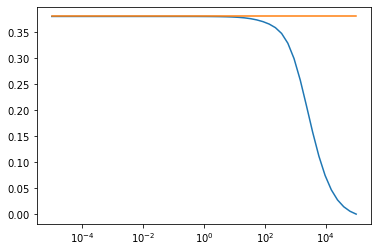

argmin : 49 ⇒ score : -0.00022616092536931198 ⇒ alpha : 100000.0


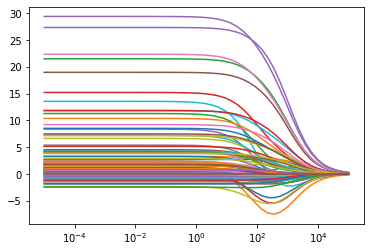

In [59]:
from sklearn import linear_model

import numpy as np
n_alphas = 50
alphas = np.logspace(-5, 5, 50)   # distribution logarithmique entre 10^-5 et 10^5

ridge = linear_model.Ridge()

coefs, scores = [], []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(dataset._X_test, dataset.Y_test.ie)) #np.mean((ridge.predict(_X_test) - y_test) ** 2))

import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(alphas, scores, [10**-5, 10**5], [baseline_err, baseline_err])
ax.set_xscale('log')
plt.show()

# meilleur paramètre
i = np.argmin(scores)
score = scores[i]
print('argmin :', i, '⇒ score :', score, '⇒ alpha :', alphas[i])

# chemin de régularisation
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.show()

## Recherche des meilleurs paramètres

# Lasso

Régression linéaire pénalisée par norme $\ell_1$.

User Guide | [1.1.3. **Lasso**](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

Meilleur paramètrage : $\alpha = 0,438 \Rightarrow R^2 = 0,382$

### Estimation des meilleurs paramètres

#### [Sélection de modèle Lasso à l'aide d'un critère d'information](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-an-information-criterion)

Cf. les deux critères implémentés par SKL :
* **AIC** *Akaike Information Criterion*
* **BIC** *Bayes Information Criterion*


Lasso IC selection for target ie


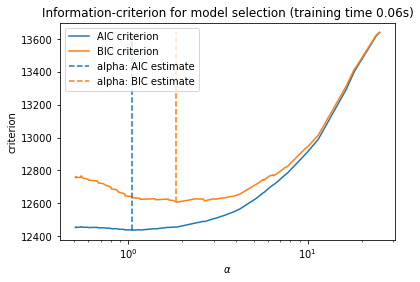

alpha: AIC estimate : 1.0458576410635378
alpha: BIC estimate : 1.8545714208090018


In [8]:
from pepper_commons import print_subtitle               # pretty print
from pepper_skl_commons import lasso_best_from_ic

best_alphas = dict()
best_alphas['aic'] = []
best_alphas['bic'] = []
print_subtitle(f'Lasso IC selection for target {target}')
_, alpha_aic, alpha_bic, _ = lasso_best_from_ic(X, y, show_tab=False, show_plot=True)
# _ ⇒ results, alpha_aic, alpha_bic, fit_time
best_alphas['aic'] += [alpha_aic]
best_alphas['bic'] += [alpha_bic]

#### [Sélection de modèle Lasso par validation croisée : descente de coordonnées](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation)


Lasso CD CV selection for target ie


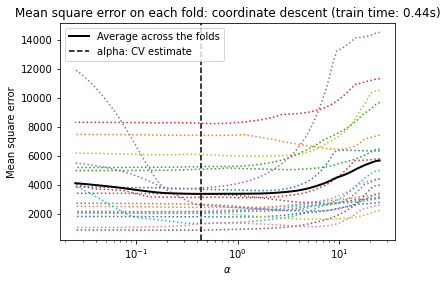

alpha: CD CV estimate : 0.43978440444985856


In [9]:
from pepper_skl_commons import lasso_best_from_cd_cv

best_alphas['cd_cv'] = []
print_subtitle(f'Lasso CD CV selection for target {target}')
y = Y[target]
alpha_, _, _, _, _ = lasso_best_from_cd_cv(X, y, show_tab=False, show_plot=True)
# _ ⇒  alpha_, mse_path_mean, alphas_, mse_path_, fit_time
best_alphas['cd_cv'] += [alpha_]

#### [Sélection de modèle Lasso par validation croisée : régression du moindre angle](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation)


Lasso LARS CV selection for target ie


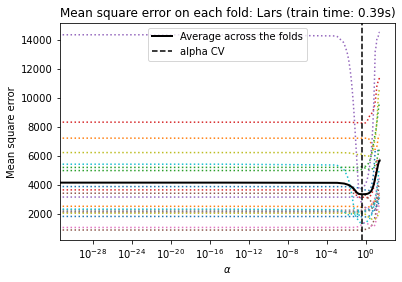

alpha: LARS VC estimate : 0.4234958729895697


In [10]:
from pepper_skl_commons import lasso_best_from_lars_cv

best_alphas['lars_cv'] = []
print_subtitle(f'Lasso LARS CV selection for target {target}')
y = Y[target]
alpha_, _, _, _, _ = lasso_best_from_lars_cv(X, y, show_tab=False, show_plot=True)
# _ ⇒  alpha_, mse_path_mean, alphas_, mse_path_, fit_time
best_alphas['lars_cv'] += [alpha_]

#### Synthèse

In [12]:
import pandas as pd
best_alphas_df = pd.DataFrame.from_dict(best_alphas)
best_alphas_df.index = [target]
display(best_alphas_df)

,aic,bic,cd_cv,lars_cv
ie,1.045858,1.854571,0.439784,0.423496


### Recherche des paramètres optimaux

In [50]:
from sklearn import linear_model
import numpy as np
from pepper_skl_commons import search_best_params

model = linear_model.Lasso
param_grid = {'alpha': np.linspace(.2, 2, 1000)}
scores, best_params, best_score, nested_score, cv_results = \
    search_best_params(dataset, target, model, param_grid, cv=10, verbose=False, scale=True)

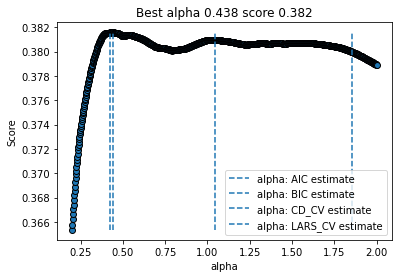

In [51]:
import matplotlib.pyplot as plt
def plot_alpha_score(est_alpha, alphas, scores, best_alpha, best_score):
    fig, ax = plt.subplots()
    ax.scatter(alphas, scores, edgecolors=(0, 0, 0))
    for c in est_alpha.columns:
        ax.vlines(
            est_alpha[c][0],
            scores.min(),
            scores.max(),
            label=f"alpha: {c.upper()} estimate",
            linestyle="--"
        )
    ax.set_xlabel("alpha")
    ax.set_ylabel("Score")
    ax.set_title(f'Best alpha {round(best_alpha,3)} score {round(best_score, 3)}')
    ax.legend()
    plt.show()

est_alpha = best_alphas_df
alphas = cv_results.param_alpha
scores = cv_results.mean_test_score
best_alpha = best_params['alpha']
plot_alpha_score(est_alpha, alphas, scores, best_alpha, best_score)